In [1]:
import torch
import torch.nn.functional as F

from mscgpt.data_handler import DataHandler
from mscgpt.tokenizer import Tokenizer
from mscgpt.gpt import MicroSCGPT, GeneExpressionRegressor

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
CONTEXT_SIZE = 128
LEARNING_RATE = 1e-4
N_HEADS = 4
N_LAYERS = 8
N_EMBED = 256
N_EPOCHS = 5
INTERVAL_EVAL = 100
N_EVAL = 200
DROPOUT = .1
MASK_P = .2

In [3]:
import os

tk = Tokenizer()
dh = DataHandler(BATCH_SIZE, CONTEXT_SIZE, tk.pad_token, device=DEVICE)

for fname in os.listdir('/home/risitop/Code/micro-scgpt/data/pretrain/'):
    print(f"Loading {fname}...")
    tokenized_data = tk.load_pretraining_dataset(fname.split('.')[0])
    dh.load_dataset(tokenized_data)

print(f"Pretraining dataset size: {dh.training_set_size} cells.")

> Tokenizer: 19257 genes successfully loaded.
Loading immunecells_frac2.tk...
> Data Handler: Dataset successfully loaded.
Loading tabmuris_A.tk...
> Data Handler: Dataset successfully loaded.
Loading immunecells_frac0.tk...
> Data Handler: Dataset successfully loaded.
Loading immunecells_frac1.tk...
> Data Handler: Dataset successfully loaded.
Loading immunecells_frac3.tk...
> Data Handler: Dataset successfully loaded.
Loading humaneye.tk...
> Data Handler: Dataset successfully loaded.


In [5]:
@torch.no_grad()
def estimate_loss(model_gpt, model_gexpr, eval_iters):
  out = {}
  model_gpt.eval()
  model_gexpr.eval()
  for split in ('train', 'val'):
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
      x_gid, x_bin = dh.get_batch(split)
      masked_gid, masked_bin, mask = dh.generate_mask(x_gid, x_bin, tk.pad_token, MASK_P)
      x_emb = model_gpt(masked_gid, masked_bin)
      estimate = model_gexpr(x_emb)
      losses[k] = dh.gene_expression_loss(x_gid, x_bin, estimate, mask).item()
    out[split] = losses.mean()
  model_gpt.train()
  model_gexpr.train()
  return out

In [6]:
gpt = MicroSCGPT(CONTEXT_SIZE, tk.bins_size, tk.vocab_size, N_HEADS, N_LAYERS, N_EMBED, N_EMBED, DROPOUT)
gexpr = GeneExpressionRegressor(CONTEXT_SIZE, N_EMBED, tk.n_genes)
gpt = gpt.to(DEVICE)
gexpr = gexpr.to(DEVICE)
optimizer = torch.optim.AdamW(
  list(gpt.parameters()) + list(gexpr.parameters()), 
  lr=LEARNING_RATE
)

> MicroSCGPT: Model initialized with 8494336 parameters.


In [7]:
print(f'> Starting training on {DEVICE}: {torch.cuda.get_device_name(0)}.')

STEPS_PER_EPOCH = dh.training_set_size // BATCH_SIZE # Every cell seen on average once
N_TRAIN_STEPS = N_EPOCHS * STEPS_PER_EPOCH

print(f"> #epochs: {N_EPOCHS}, #steps per epoch: {STEPS_PER_EPOCH}, #total steps: {N_TRAIN_STEPS}")

rec_loss = []
for step in range(N_TRAIN_STEPS):
  if step > 0 and not step % (STEPS_PER_EPOCH): # LR decay every epoch
    optimizer.param_groups[0]["lr"] *= 0.9
  if not (step % INTERVAL_EVAL) or step == N_TRAIN_STEPS - 1:
    loss = estimate_loss(gpt, gexpr, N_EVAL)
    print(f'Step {step}, loss={(1000*loss["train"]):.3f}e-3 (train), {(1000*loss["val"]):.3f}e-3 (val)')
  x_gid, x_bin = dh.get_batch("train")
  masked_gid, masked_bin, mask = dh.generate_mask(x_gid, x_bin, tk.pad_token, MASK_P)
  x_emb = gpt(masked_gid, masked_bin)
  estimate = gexpr(x_emb)
  loss = dh.gene_expression_loss(x_gid, x_bin, estimate, mask)
  rec_loss.append(float(loss.detach()))
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

> Starting training on cuda: Radeon RX 7900 XT.
> #epochs: 5, #steps per epoch: 12563, #total steps: 62815


/home/risitop/.local/share/virtualenvs/micro-scgpt-GeTqRLZN/lib/python3.10/site-packages/torch/nn/modules/transformer.py:685: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:264.)
  return torch._transformer_encoder_layer_fwd(
/home/risitop/.local/share/virtualenvs/micro-scgpt-GeTqRLZN/lib/python3.10/site-packages/torch/nn/modules/transformer.py:685: UserWarning: 1Torch was not compiled with memory efficient attention. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:320.)
  return torch._transformer_encoder_layer_fwd(


Step 0, loss=2.410e-3 (train), 2.492e-3 (val)
Step 100, loss=2.306e-3 (train), 2.346e-3 (val)
Step 200, loss=2.348e-3 (train), 2.269e-3 (val)
Step 300, loss=2.140e-3 (train), 2.221e-3 (val)
Step 400, loss=1.994e-3 (train), 1.997e-3 (val)
Step 500, loss=1.857e-3 (train), 1.906e-3 (val)
Step 600, loss=1.763e-3 (train), 1.736e-3 (val)
Step 700, loss=1.610e-3 (train), 1.693e-3 (val)
Step 800, loss=1.477e-3 (train), 1.579e-3 (val)
Step 900, loss=1.408e-3 (train), 1.444e-3 (val)
Step 1000, loss=1.290e-3 (train), 1.341e-3 (val)
Step 1100, loss=1.206e-3 (train), 1.204e-3 (val)
Step 1200, loss=1.121e-3 (train), 1.186e-3 (val)
Step 1300, loss=1.012e-3 (train), 1.101e-3 (val)
Step 1400, loss=0.975e-3 (train), 1.028e-3 (val)
Step 1500, loss=0.872e-3 (train), 0.973e-3 (val)
Step 1600, loss=0.822e-3 (train), 0.899e-3 (val)
Step 1700, loss=0.781e-3 (train), 0.860e-3 (val)
Step 1800, loss=0.719e-3 (train), 0.799e-3 (val)
Step 1900, loss=0.653e-3 (train), 0.734e-3 (val)
Step 2000, loss=0.607e-3 (train)

Text(0, 0.5, 'log(loss)')

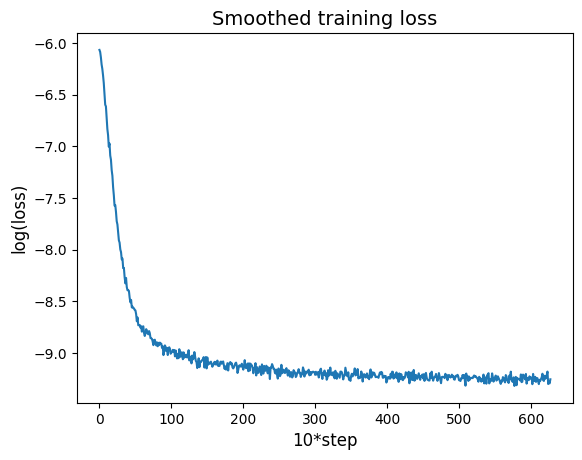

In [10]:
import matplotlib.pyplot as plt

plt.plot(torch.tensor(rec_loss[:-15]).view(-1, 100).log().mean(axis=-1))
plt.title("Smoothed training loss", fontsize=14)
plt.xlabel("10*step", fontsize=12)
plt.ylabel("log(loss)", fontsize=12)

In [10]:
# The training loss seems to have settled :)
# Total running time: 49min41 (we approach the limits of my single GPU)
# Average speed: 21 it/s

In [11]:
# Saving pretraining parameters
torch.save(gpt.state_dict(), '/home/risitop/Code/micro-scgpt/data/assets/gpt.params')
torch.save(gexpr.state_dict(), '/home/risitop/Code/micro-scgpt/data/assets/gexpr.params')